In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

# Load Data

In [2]:
df = pd.read_csv('~/Downloads/interview/Task 1 DNA_sequences.csv')

In [3]:
# Brief look at the data
df.head()

,Unnamed: 0,Sequences,labels
0,1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [4]:
sequences = df['Sequences']
labels = df['labels']

In [5]:
# use one-hot encoding to get each DNA sequence in the form of a matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()
# The OneHotEncoder converts an array of integers to a sparse matrix where
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One-hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One-hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
# use one-hot encoding to encode the labels -> assuming '0' if protein unbound, '1' if protein bound.
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[0 0 0 ... 0 1 1]]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


In [7]:
# split the data into training and test sets
# partition the training set into a training and validation set.
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

In [8]:
print(train_features.shape[1])

50


# Model Building and Evaluation

Build a model (preferably a deep learning classifier) to predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

In [51]:
# First, load in tensorflow's Keras API for model building
import tensorflow as tf
from tensorflow.keras.models import Sequential # a simple sequential model is appropriate
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout # necessary for the layers I want in my network, more detail below.
from keras.callbacks import EarlyStopping # for validation loss monitoring

In [35]:
# Check class balance in the raw data, as that will influence macro- or micro-averaging for accuracy, precision and recall measures.
class_distribution = df['labels'].value_counts(normalize=True) * 100
print(class_distribution)

labels
0    50.65
1    49.35
Name: proportion, dtype: float64


Given that this is a binary classification problem, the precision, recall, and accuracy measures will be nearly identical since the classes are balanced. As such, I will use the accuracy metric from keras rather than calculate accuracy, recall and precision manually.

In [41]:
# CNN would be appropriate for identifying relevant motif pattern(s) in DNA sequences, and from my understanding of the i4Health team they are very knowledgeable on the applications of CNNs on healthcare data
# Dr. Daniel Quang gave an example of a hybrid CNN/RNN for DNA-Seq quantification, which I will base some hyperparameters on (see  https://doi.org/10.1093/nar/gkw226)
def build_model(input_shape):
    model = Sequential()
    
    # 1D convolutional layer as the first layer, for capturing motifs (patterns) in the sequences
    model.add(Conv1D(filters=32, kernel_size=12, activation='relu', input_shape=input_shape)) 

    # Add 1D MaxPooling layer to downsample output from convolutional layer, preserving prominent features and removing less prominent ones, which increases computational efficiency and reduces risk of overfitting
    model.add(MaxPooling1D(pool_size=4)) 

    # Regularize by randomly dropping one in five nodes (convolutional + MaxPooling layers as input) from each update cycle (see Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958.)
    model.add(Dropout(0.2))

    # Convert 2D input to 1D array before feeding into dense layer. More detail can be seen after model.summary() below.
    model.add(Flatten())
    
    # Dense layer for integrating information from previous layers. 
    model.add(Dense(16, activation='relu')) # relu activation function is widely accepted as appropriate for a classification task like this
    model.add(Dropout(0.5)) # more pruning with Dropout, before final output layer
    
    # Output layer that converts output scores from first dense layer into probabilities -> useful for interpreting the network's output as the probability distribution over the two classes: "binds to the TF/protein" vs. "doesn't bind".
    model.add(Dense(2, activation='softmax')) 

    # Compile the model, using ADAM optimization model and categorical_crossentropy loss function based on keras documentation suggestion for probibalistic data with two label classes.
    # In this example, using categorical_accuracy as an accuracy metric will yield identical results to using binary accuracy since it is a binary question of "protein binds"/"doesn't bind", but I felt the need to demonstrate my understanding of the categorical_accuracy metric's use for one-hot encoded data.
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model
    

In [42]:
def DNN_classifier():
    input_shape = (train_features.shape[1], train_features.shape[2])
    ml = build_model(input_shape)

    # Epochs/batch_size are somewhat arbitrary here
    # EarlyStopping callback will stop training once the validation loss hasn't improved for 5 epochs (patience=5), and restores the model weights from the epoch with the best validation loss.
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = ml.fit(train_features, train_labels, epochs=50, validation_split=0.2, batch_size=32, verbose=1, callbacks=[early_stop])

    return ml, history

In [43]:
# Train the classifier, store model progress in "history"
model, history = DNN_classifier()

Epoch 1/50
38/38 [==============================] - 1s 7ms/step - loss: 0.6933 - categorical_accuracy: 0.5200 - val_loss: 0.6712 - val_categorical_accuracy: 0.6667
Epoch 2/50
38/38 [==============================] - 0s 3ms/step - loss: 0.6433 - categorical_accuracy: 0.6317 - val_loss: 0.5740 - val_categorical_accuracy: 0.8267
Epoch 3/50
38/38 [==============================] - 0s 3ms/step - loss: 0.5611 - categorical_accuracy: 0.7167 - val_loss: 0.4640 - val_categorical_accuracy: 0.8467
Epoch 4/50
38/38 [==============================] - 0s 3ms/step - loss: 0.4651 - categorical_accuracy: 0.7925 - val_loss: 0.3592 - val_categorical_accuracy: 0.8767
Epoch 5/50
38/38 [==============================] - 0s 3ms/step - loss: 0.3814 - categorical_accuracy: 0.8417 - val_loss: 0.2679 - val_categorical_accuracy: 0.9100
Epoch 6/50
38/38 [==============================] - 0s 3ms/step - loss: 0.3087 - categorical_accuracy: 0.8742 - val_loss: 0.2072 - val_categorical_accuracy: 0.9333
Epoch 7/50
38/38

In [44]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 39, 32)            1568      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 9, 32)             0         
 g1D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 9, 32)             0         
                                                                 
 flatten_7 (Flatten)         (None, 288)               0         
                                                                 
 dense_14 (Dense)            (None, 16)                4624      
                                                                 
 dropout_15 (Dropout)        (None, 16)                0         
                                                      

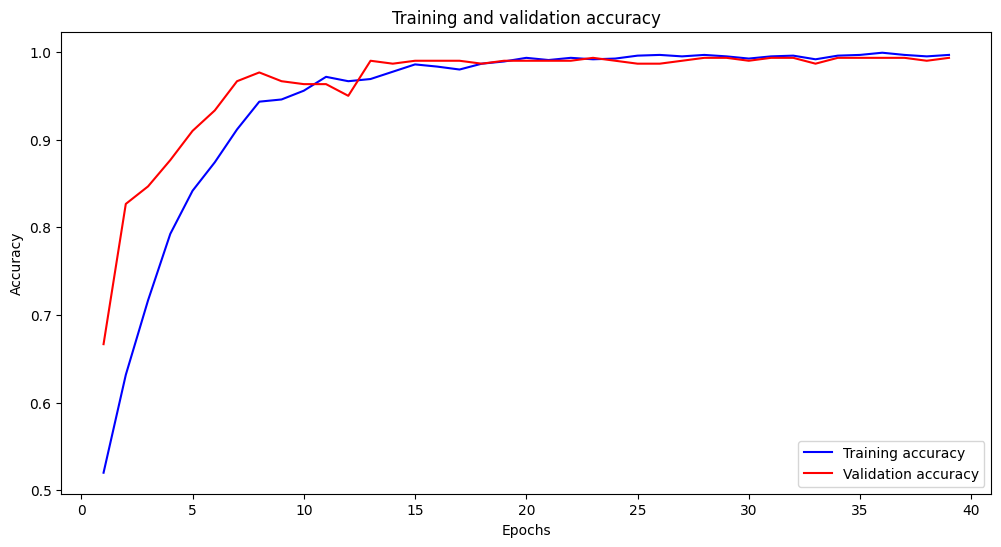

In [45]:
# evaluate and report the performance of the model

# First, get the accuracy data from "history"
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

# Create epochs range
epochs = range(1, len(acc) + 1)

# Plot "binary accuracy" i.e. training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Based on the above plot, the model reaches an accuracy plateau around epoch 20, and a peak accuracy consistently greater than 99.85%.

16/16 [==============================] - 0s 1ms/step


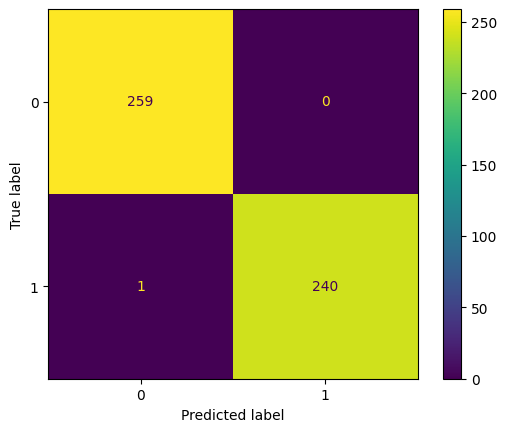

In [46]:
#print (confusion matrix)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the binary labels using the model
predictions = model.predict(test_features)

# Convert from one-hot encoding to indices
predicted_labels = np.argmax(predictions, axis=1) 
true_labels = np.argmax(test_labels, axis=1) 

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

The model is quite accurate and precise, given that there are very few (if any) false positives and false negatives.

# Visualization and Interpretation

Generating a saliency map based on the method of [Lanchantin *et al.*](10.1142/9789813207813_0025).

In [71]:
# compute a saliency map [the gradient of the model's prediction with respect to each individual nucleotide]
# i.e. a weighted sum of the input nucleotides, where each "weight" indicates the influence of said nucleotide's position on the output score.

#Select an Input Sequence
seq_index = 0  # Just an example, choose any index
input_seq = tf.convert_to_tensor(train_features[seq_index:seq_index+1]) # input_seq must be presented as an array to GradientTape()

#Compute the Gradient
def compute_saliency(model, data):

    # set model to evaluation mode
    model.trainable = False

    with tf.GradientTape() as tape:
        tape.watch(data)
        predictions = model(data)
        # Compute the saliency for the class with the highest score.
        predicted_class = tf.argmax(predictions[0])
        score = predictions[0][predicted_class]

    # Compute the gradient
    gradient = tape.gradient(score, data)

    # Return the gradient
    return gradient.numpy()

#saliency_map = compute_saliency(model, input_seq)
saliency_map = compute_saliency(model, input_seq)

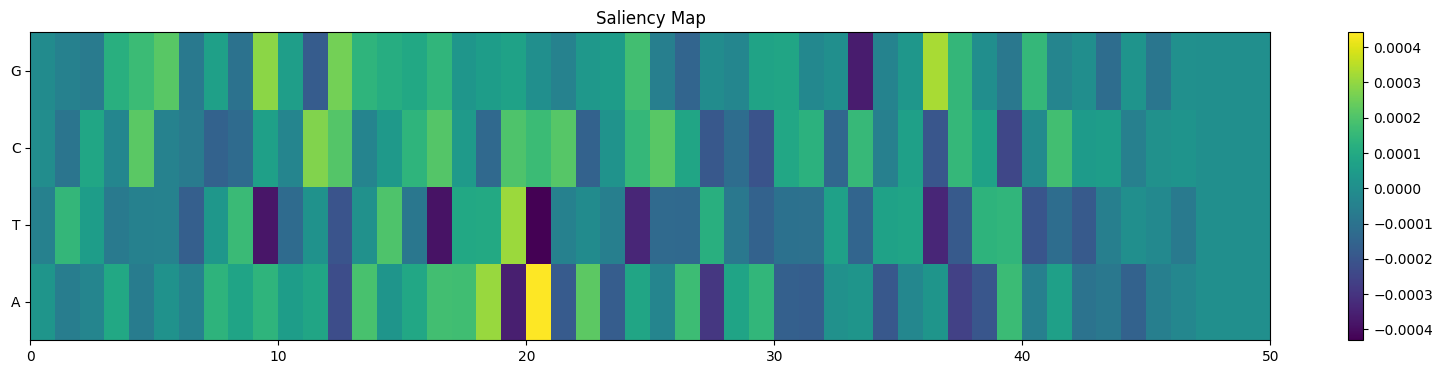

In [72]:
# Visualize
plt.figure(figsize=(20, 4))
plt.pcolor(saliency_map[0].T, cmap='viridis')
plt.yticks([0.5, 1.5, 2.5, 3.5], ['A', 'T', 'C', 'G'])
plt.colorbar()
plt.title('Saliency Map')
plt.show()

In terms of interpreting the saliency map, high scores represent a nucleotide that is important for overall class prediction. The absolute saliency score of a nucleotide at a specific location is not as important, because it is relative to the range of saliency values for that nucleotide sequence.